In [ ]:
We now have a clean, merged dataset with key features (age, LOS, mortality). The visualizations and calculations allow us to:
Understand patient demographics.
Track hospital activity over time.
Analyze resource utilization.
Identify high-risk admissions.
Prepare data for predictive modeling or further epidemiological studies.

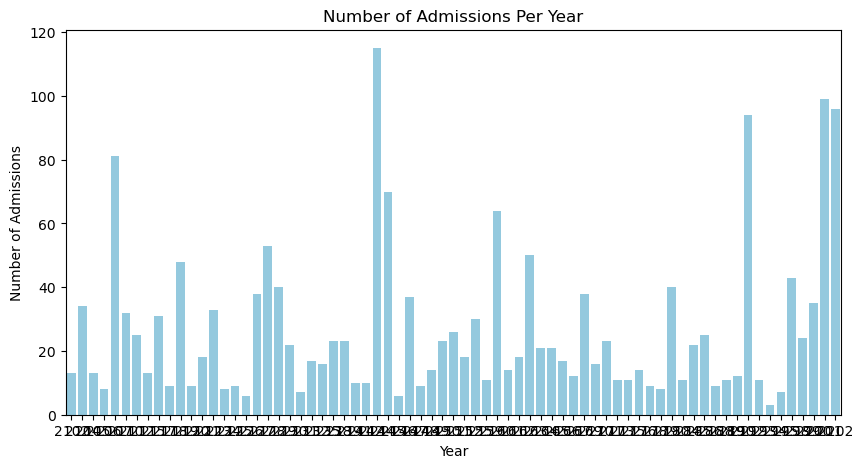

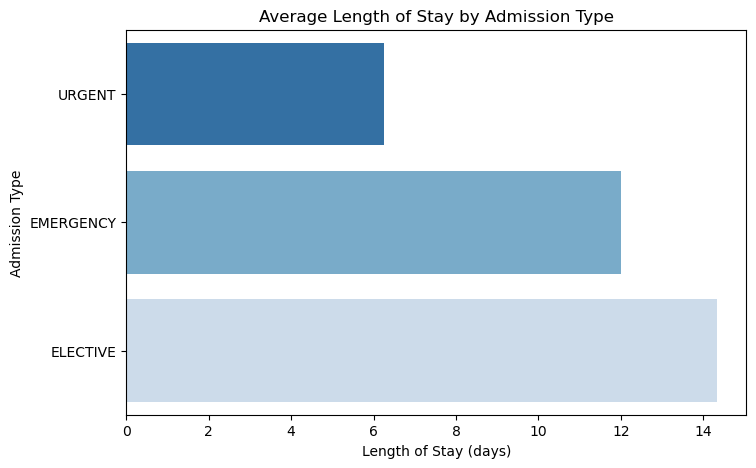

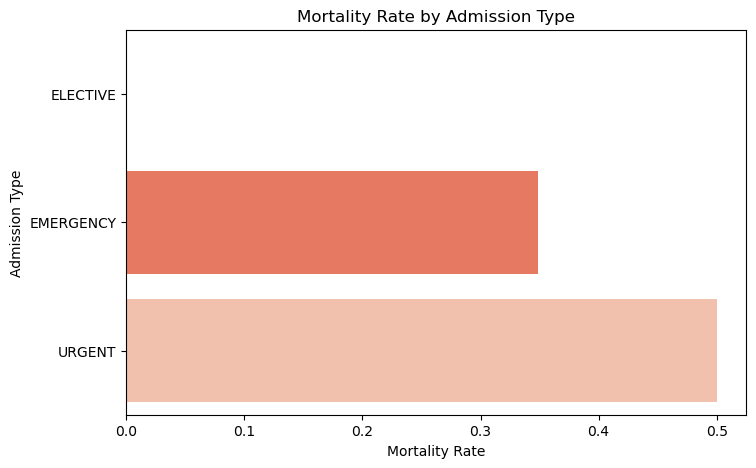

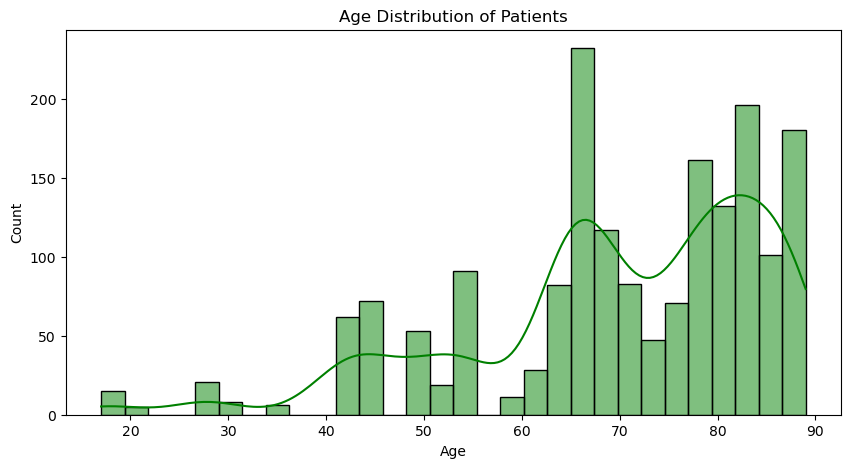

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- Load Datasets -------------------
admissions = pd.read_csv("ADMISSIONS.csv")
patients = pd.read_csv("PATIENTS.csv")
icustays = pd.read_csv("ICUSTAYS.csv")
diagnoses = pd.read_csv("DIAGNOSES_ICD.csv")

# ------------------- Merge Tables -------------------
admissions_full = pd.merge(admissions, patients, on='subject_id', how='left', suffixes=('', '_patient'))
admissions_full = pd.merge(admissions_full, icustays, on='hadm_id', how='left', suffixes=('', '_icu'))

# Drop duplicate columns from diagnoses
diagnoses = diagnoses.drop(columns=[c for c in diagnoses.columns if c in admissions_full.columns and c != 'hadm_id'])
admissions_full = pd.merge(admissions_full, diagnoses, on='hadm_id', how='left', suffixes=('', '_diag'))

# ------------------- Data Preprocessing -------------------
# Convert date columns safely
for col in ['admittime', 'dischtime', 'deathtime', 'dob']:
    if col in admissions_full.columns:
        admissions_full[col] = pd.to_datetime(admissions_full[col], errors='coerce')

# Mortality flag
admissions_full['death_flag'] = admissions_full['deathtime'].notnull().astype(int)

# Extract admission year
admissions_full['admit_year'] = admissions_full['admittime'].dt.year

# Length of stay in days
admissions_full['los_days'] = (admissions_full['dischtime'] - admissions_full['admittime']).dt.total_seconds() / (24*3600)

# ------------------- Safe Age Calculation -------------------
# Filter DOBs: only keep if birth year >= admittime.year - 120
admissions_full['birth_year'] = admissions_full['dob'].dt.year
admissions_full['admit_year'] = admissions_full['admittime'].dt.year

valid_age_mask = (admissions_full['birth_year'].notnull()) & (admissions_full['admit_year'].notnull()) & \
                 (admissions_full['admit_year'] - admissions_full['birth_year'] <= 120)

admissions_full.loc[valid_age_mask, 'age'] = admissions_full.loc[valid_age_mask, 'admit_year'] - admissions_full.loc[valid_age_mask, 'birth_year']

# ------------------- Epidemiological Analysis -------------------
admissions_per_year = admissions_full['admit_year'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=admissions_per_year.index, y=admissions_per_year.values, color='skyblue')
plt.title("Number of Admissions Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.show()

# ------------------- Resource Allocation -------------------
los_by_type = admissions_full.groupby('admission_type')['los_days'].mean().sort_values()
plt.figure(figsize=(8,5))
df_los = los_by_type.reset_index().rename(columns={'admission_type': 'type', 'los_days': 'los'})
sns.barplot(x='los', y='type', data=df_los, hue='type', dodge=False, palette='Blues_r', legend=False)
plt.title("Average Length of Stay by Admission Type")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Admission Type")
plt.show()

# ------------------- Predictive Modeling -------------------
mortality_by_type = admissions_full.groupby('admission_type')['death_flag'].mean().sort_values()
plt.figure(figsize=(8,5))
df = mortality_by_type.reset_index().rename(columns={'admission_type': 'type', 'death_flag': 'mortality'})
sns.barplot(x='mortality', y='type', data=df, hue='type', palette='Reds_r', dodge=False, legend=False)
plt.title("Mortality Rate by Admission Type")
plt.xlabel("Mortality Rate")
plt.ylabel("Admission Type")
plt.show()

print()
# ------------------- Demographic Analysis -------------------
plt.figure(figsize=(10,5))
sns.histplot(admissions_full['age'].dropna(), bins=30, kde=True, color='green')
plt.title("Age Distribution of Patients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()
